In this notebook, we attempt to replicate the gradient flow plots from [1, pp. 8-9]. We also analyze additional loss functions from [2], [3] and other commonly used such as Binary cross-entropy, MSE and MAE.

## References

[1] Diakogiannis, F. I., Waldner, F., Caccetta, P., & Wu, C. (2020). **ResUNet-a: A deep learning framework for semantic segmentation of remotely sensed data.** ISPRS Journal of Photogrammetry and Remote Sensing, 162, 94-114. URL: https://arxiv.org/abs/1904.00592

[2] Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). **Focal loss for dense object detection**. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988). URL: https://arxiv.org/abs/1708.02002

[3] Jadon, S. (2020, October). **A survey of loss functions for semantic segmentation**. In 2020 IEEE Conference on Computational Intelligence in Bioinformatics and Computational Biology (CIBCB) (pp. 1-7). IEEE. URL: https://arxiv.org/abs/2006.14822

[4] Abraham, N., & Khan, N. M. (2019, April). **A novel focal tversky loss function with improved attention u-net for lesion segmentation**. In 2019 IEEE 16th International Symposium on Biomedical Imaging (ISBI 2019) (pp. 683-687). IEEE. URL: https://arxiv.org/abs/1810.07842

## Definitions

The authors in [1] consider a toy example with only 2 pixels, so that the gradient flow can be visualized in a 2D plot.

* $i$ indexes a pixel.

* Prediction: $p = (p_1, p_2) \in [0, 1]^2$. We use a linearly spaced grid of values for $p_1$ and $p_2$.

* Ground truth / Target: $l = (l_1, l_2) \in [0, 1]^2$.

## Main goal

The main goal of the plots in [1] is to study the gradient flow properties of various Dice loss variants. A quality loss function should have a gradient flow that directs the solution towards the ground truth from any starting point. Also, better solutions follow shorter paths, which manifests as straight gradient flow lines. Additionally, a loss function is also suitable for regression of continuous variables (in the $[0, 1]$ range) if the gradient flow lines are symmetric around the target.

## Code

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def plot_fn(fn, l=[1.0, 0.0], r=[0.0, 1.0], n=10, 
             fn_kwargs=dict(),
            plt_kwargs=dict(),):
  p1, p2 = tf.meshgrid(tf.linspace(r[0], r[1], n+1),
                      tf.linspace(r[0], r[1], n+1),)
  l1, l2 = tf.meshgrid(tf.repeat(l[0], n+1),
                      tf.repeat(l[1], n+1))
  loss = fn(p1, p2, l1, l2, **fn_kwargs)

  print("Max: ", np.max(loss))
  print("Min: ", np.min(loss))

  fig, ax = plt.subplots(1, 1, figsize=(4.5, 4), sharex=True, sharey=True)
  ax.set_title("Function")
  ax.set_ylabel("$p_2$")
  ax.set_xlabel("$p_1$")
  cmap = mpl.cm.get_cmap(plt_kwargs.get("cmap", "magma"))
  cmap.set_bad(color="red", alpha=1.0)
  norm = plt_kwargs.get("gnorm", None)
  levels = plt_kwargs.get("levels", 6)
  cf = ax.contourf(p1.numpy(), p2.numpy(), loss, levels, cmap=cmap, norm=norm, alpha=0.5)
  cs = ax.contour(p1.numpy(), p2.numpy(), loss, levels)
  ax.clabel(cs, inline=1, fontsize=10)
  fig.colorbar(cf, ax=ax)

  if "xlim" in plt_kwargs:
    ax.set_xlim(plt_kwargs["xlim"])

  if "ylim" in plt_kwargs:
    ax.set_ylim(plt_kwargs["ylim"])

  ax.plot(l1, l2, marker="x", markersize=5, color="red")

  fig.tight_layout()
  return fig

In [3]:
def plot_dfn(fn, l=[1.0, 0.0], r=[0.0, 1.0], n=10, fn_kwargs=dict(),
           plt_kwargs=dict()):
  """
  Arguments
  ---------
  fn
    The loss function.
  l
    The GT vector.
  r
    The range of values (i.e. p \in [r[0], r[1]]).
  n
    The number of samples.
  fn_kwargs
    Keyword arguments to the invoke the loss function with.
  plt_kwargs
    Keyword arguments for plotting.
  """
  p1, p2 = tf.meshgrid(tf.linspace(r[0], r[1], n+1),
                      tf.linspace(r[0], r[1], n+1),)
  l1, l2 = tf.meshgrid(tf.repeat(l[0], n+1),
                      tf.repeat(l[1], n+1))

  p1v = tf.Variable(p1, name="p1")
  p2v = tf.Variable(p2, name="p2")
  l1v = tf.Variable(l1, name="l1")
  l2v = tf.Variable(l2, name="l2")
  with tf.GradientTape(persistent=True) as tape2:
    with tf.GradientTape(persistent=True) as tape:
      loss = fn(p1v, p2v, l1v, l2v, **fn_kwargs)
    grad = tape.gradient(loss, [p1v, p2v])
  grad2 = tape2.gradient(grad, [p1v, p2v])
  gx, gy = grad
  gradnorm = np.ma.masked_invalid(
      np.linalg.norm(np.stack([gx.numpy(), gy.numpy()]), axis=0)
  )
  grad21, grad22 = grad2
  lap = grad21 + grad22

  fig, ax = plt.subplots(1, 2, figsize=(8.5, 4), sharex=True, sharey=True)

  ax[0].set_title("Gradient")
  ax[0].set_ylabel("$p_2$")
  ax[0].set_xlabel("$p_1$")
  cmap = mpl.cm.get_cmap(plt_kwargs.get("cmap", "magma"))
  cmap.set_bad(color="red", alpha=1.0)
  norm = plt_kwargs.get("gnorm", None)
  levels = plt_kwargs.get("levels", 6)
  cf = ax[0].contourf(p1v.numpy(), p2v.numpy(), gradnorm, levels, cmap=cmap, norm=norm, alpha=0.5)
  cs = ax[0].contour(p1v.numpy(), p2v.numpy(), gradnorm, levels)
  ax[0].clabel(cs, inline=1, fontsize=10)
  ax[0].quiver(p1v.numpy(),
            p2v.numpy(),
            gx.numpy(),
            gy.numpy(),
            color="black",
            )
  ax[0].plot(l1, l2, marker="x", markersize=5, color="red")
  fig.colorbar(cf, ax=ax[0])

  ax[1].set_title("Laplacian")
  norm = plt_kwargs.get("lnorm", None)
  cf = ax[1].contourf(p1v.numpy(), p2v.numpy(), lap, levels, cmap=cmap, norm=norm, alpha=0.5)
  cs = ax[1].contour(p1v.numpy(), p2v.numpy(), lap, levels)
  ax[1].clabel(cs, inline=1, fontsize=10)
  ax[1].plot(l1, l2, marker="x", markersize=5, color="red")
  ax[1].set_ylabel("$p_2$")
  ax[1].set_xlabel("$p_1$")
  fig.colorbar(cf, ax=ax[1])

  if "xlim" in plt_kwargs:
    ax[0].set_xlim(plt_kwargs["xlim"])
    ax[1].set_xlim(plt_kwargs["xlim"])

  if "ylim" in plt_kwargs:
    ax[0].set_ylim(plt_kwargs["ylim"])
    ax[1].set_ylim(plt_kwargs["ylim"])


  fig.tight_layout()
  return fig

In [10]:
def call_fn(fn, p1, p2, l1, l2, **kwargs):
  return fn(tf.constant([p1]),
            tf.constant([p2]),
            tf.constant([l1]),
            tf.constant([l2]), **kwargs)

## Parameters

Example parameters from the paper.

### Binary target

When $l_i \in \{0,1\}$

In [4]:
lb = [1.0, 0.0]
rb = [0.0, 1.0]
nb = 10

We add some unit tests for the binary target case:

In [5]:
def unit_test_binary(fn, atol=1e-7, **kwargs):
  np.testing.assert_allclose(call_fn(fn, 0.0, 0.0, 0.0, 0.0, **kwargs).numpy(), 1.0)
  np.testing.assert_allclose(call_fn(fn, 1.0, 0.0, 1.0, 0.0, **kwargs).numpy(), 1.0)
  np.testing.assert_allclose(call_fn(fn, 1.0, 1.0, 1.0, 1.0, **kwargs).numpy(), 1.0)
  np.testing.assert_allclose(call_fn(fn, 1.0, 0.0, 0.0, 0.0, **kwargs).numpy(), 0.0, atol=atol)
  np.testing.assert_allclose(call_fn(fn, 1.0, 1.0, 0.0, 0.0, **kwargs).numpy(), 0.0, atol=atol)

In [6]:
def complement_unit_test_binary(fn, atol=1e-7, **kwargs):
  np.testing.assert_allclose(call_fn(fn, 0.0, 0.0, 0.0, 0.0, **kwargs).numpy(), 1.0)
  np.testing.assert_allclose(call_fn(fn, 1.0, 0.0, 1.0, 0.0, **kwargs).numpy(), 1.0)
  np.testing.assert_allclose(call_fn(fn, 1.0, 1.0, 1.0, 1.0, **kwargs).numpy(), 1.0)
  np.testing.assert_allclose(call_fn(fn, 0.0, 1.0, 1.0, 1.0, **kwargs), 0.0, atol=atol)
  np.testing.assert_allclose(call_fn(fn, 0.0, 1.0, 1.0, 1.0, **kwargs), 0.0, atol=atol)

In [7]:
def composed_unit_test_binary(fn, **kwargs):
  np.testing.assert_allclose(call_fn(fn, 0.0, 0.0, 0.0, 0.0, **kwargs).numpy(), 1.0)
  np.testing.assert_allclose(call_fn(fn, 1.0, 0.0, 1.0, 0.0, **kwargs).numpy(), 1.0)
  np.testing.assert_allclose(call_fn(fn, 1.0, 1.0, 1.0, 1.0, **kwargs).numpy(), 1.0)

### Continuous target

When $l_i \in [0, 1]$

The first one is used to study the symmetry of the gradient flow around the ground truth / target value. Losses with this property can be used for regression of a continuous variable[1].

In [ ]:
lc = [0.5, 0.5]
rc = [0.0, 1.0]
nc = 10

The second one is used as an arbitrary continuous case.

In [ ]:
lc2 = [0.25, 0.85]
rc2 = [0.0, 1.0]
nc2 = 10

We add a function to check if a function can work for regression of a continuous variable:

In [ ]:
def works_for_regression(fn, **kwargs):
  return np.allclose(call_fn(fn, 0.3, 0.0, 0.3, 0.0, **kwargs).numpy(), 1.0)

## $D_1$

$$D_1(p, l) = \frac{2 \sum_i p_i l_i}{\sum_i p_i + \sum_i l_i} $$

Source: [4]

In [ ]:
@tf.function
def d1(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  num = (2.0 * (p1 * l1 + p2 * l2)) + eps
  den = p1 + p2 + l1 + l2 + eps
  return  num / den

In [ ]:
unit_test_binary(d1)

Binary case example:

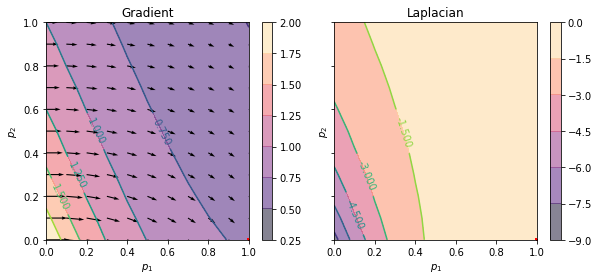

In [ ]:
fig = plot_dfn(d1, l=lb, r=rb, n=nb)

We see that it doesn't work for regression:

In [ ]:
works_for_regression(d1)

False

## $D_1$ complement
The same as $D_1$ but with the complement of the parameters.

$$ \tilde{D}_1(p, l) = D_1(\vec{1} - p, \vec{1} - l)$$

In [ ]:
@tf.function
def d1c(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  return d1(1.0 - p1, 1.0 - p2, 1.0 - l1, 1.0 - l2, eps=eps)

In [ ]:
complement_unit_test_binary(d1c)

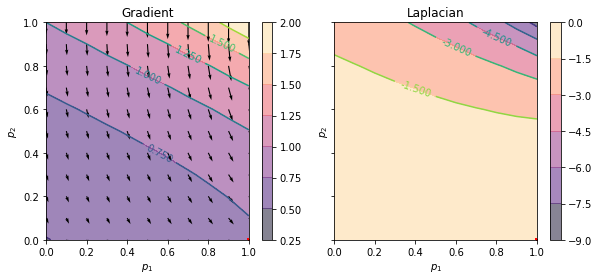

In [ ]:
fig = plot_dfn(d1c, l=lb, r=rb, n=nb)

## $D_1$ + $D_1$ complement (exploration)

In [ ]:
@tf.function
def d1m(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  return 0.5 * (d1(p1, p2, l1, l2, eps=eps) + d1c(p1, p2,l1,l2, eps=eps))

In [ ]:
composed_unit_test_binary(d1m)

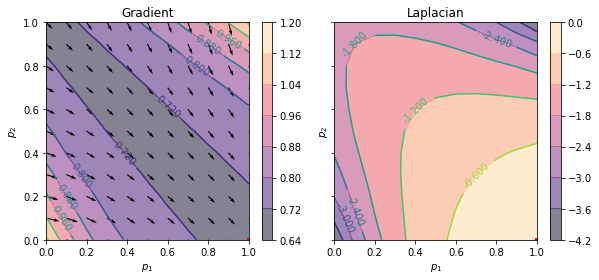

In [ ]:
fig = plot_dfn(d1m, l=lb, r=rb, n=nb)

In [ ]:
works_for_regression(d1m)

False

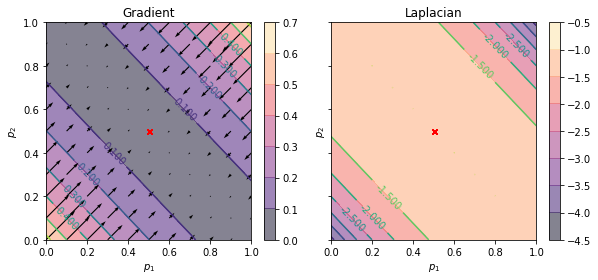

In [ ]:
fig = plot_dfn(d1m, l=lc, r=rc, n=nc)

## Tversky

In [13]:
@tf.function
def tversky(p1, p2, l1, l2, alpha=0.6, beta=None, gamma=None, eps=tf.keras.backend.epsilon()):
  # We add the gamma parameter to control the focus in a similar approach to the focal loss [2].
  # If gamma is None, this function is identical to the original Tversky loss.
  if beta is None:
    beta =  1.0 - alpha

  p1c = 1.0 - p1
  p2c = 1.0 - p2
  l1c = 1.0 - l1
  l2c = 1.0 - l2

  w1 = 1.0
  w2 = 1.0
  if gamma is not None:
    q1 = (l1 * p1) + (l1c * p1c)
    w1 = tf.math.pow(1.0 - q1, gamma)
    q2 = (l2 * p2) + (l2c * p2c)
    w2 = tf.math.pow(1.0 - q2, gamma)

  tp = w1 * p1 * l1 + w2 * p2 * l2
  fp = w1 * p1 * l1c + w2 * p2 * l2c 
  fn = w1 * p1c * l1 + w2 * p2c * l2
  return (tp + eps) / (tp + alpha * fp + beta * fn + eps)

Original Tversky:

In [19]:
unit_test_binary(tversky, atol=1e-6)

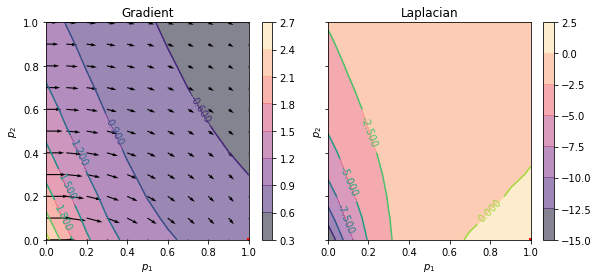

In [27]:
fig = plot_dfn(tversky, l=lb, r=rb, n=nb)

In [28]:
from google.colab import files
filename = "tversky_06.pdf"
fig.savefig(filename, bbox_inches="tight")
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We see that it doesn't work for regression:

In [ ]:
works_for_regression(tversky)

False

With per-pixel focus:

In [ ]:
unit_test_binary(tversky, atol=1e-6, gamma=1.8)

In [ ]:
fig = plot_dfn(tversky, l=lb, r=rb, n=nb, fn_kwargs=dict(gamma=1.8))

In [ ]:
unit_test_binary(tversky, atol=1e-6, gamma=4.0/3.0)

In [ ]:
fig = plot_dfn(tversky, l=lb, r=rb, n=nb, fn_kwargs=dict(gamma=4.0/3.0))

## Tversky complement

$$ \tilde{TI}(p_i, l_i) = TI(\vec{1} - p_i, \vec{1} - l_i) $$

In [21]:
@tf.function
def tversky_complement(p1, p2, l1, l2, alpha=0.6, beta=None, gamma=None, eps=tf.keras.backend.epsilon()):
  return tversky(1.0 - p1, 1.0 - p2, 1.0 - l1, 1.0 - l2, alpha=alpha, beta=beta, gamma=gamma, eps=eps)

In [22]:
# Sanity check (binary case)
complement_unit_test_binary(tversky_complement, atol=1e-6)

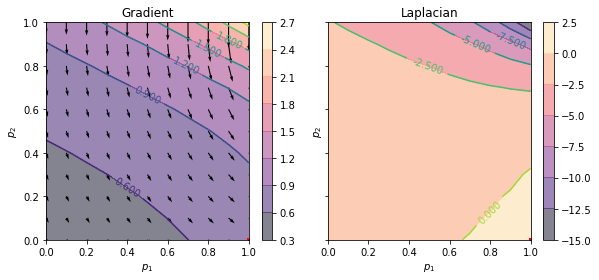

In [29]:
fig = plot_dfn(tversky_complement, l=lb, r=rb, n=nb)

In [30]:
from google.colab import files
filename = "tversky_complement_06.pdf"
fig.savefig(filename, bbox_inches="tight")
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Tversky tilde (exploration)

We follow the same approach as in [1] for the Tanimoto loss (see section below) but apply it to the Tversky loss instead.

In [24]:
@tf.function
def tversky_tilde(p1, p2, l1, l2, alpha=0.6, beta=None, gamma=None, eps=tf.keras.backend.epsilon()):
  t = tversky(p1, p2, l1, l2, alpha=alpha, beta=beta, gamma=gamma, eps=eps)
  tc = tversky_complement(p1, p2, l1, l2, alpha=alpha, beta=beta, gamma=gamma, eps=eps)
  return 0.5 * (t + tc)

In [25]:
composed_unit_test_binary(tversky_tilde)

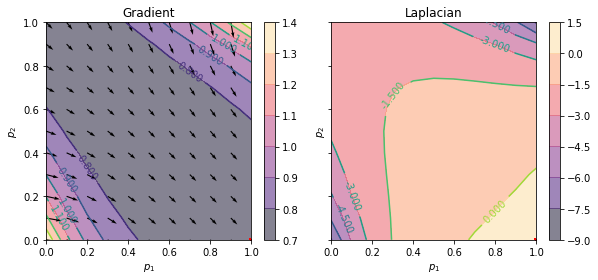

In [31]:
fig = plot_dfn(tversky_tilde, l=lb, r=rb, n=nb)

In [32]:
from google.colab import files
filename = "tversky_bi_06.pdf"
fig.savefig(filename, bbox_inches="tight")
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

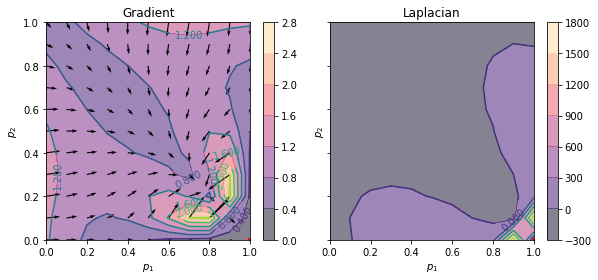

In [26]:
fig = plot_dfn(tversky_tilde, l=lb, r=rb, n=nb, fn_kwargs=dict(gamma=2.0))

We zoom in:

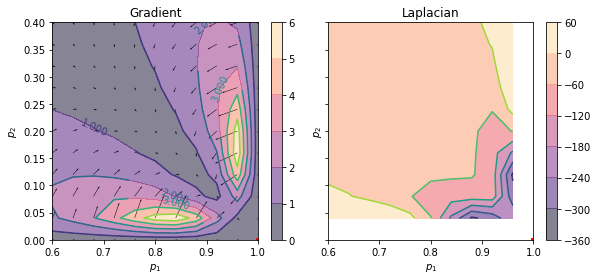

In [ ]:
fig = plot_dfn(tversky_tilde, l=lb, r=rb, n=25, fn_kwargs=dict(gamma=1.8),
              plt_kwargs=dict(xlim=(0.6, 1.0), ylim=(0.0, 0.4)),
              )

## Focal Tversky

$$ FTL_c = \sum_c (1 - TI_c)^{1/\gamma} $$

We interpret the classes as the target (foreground) and non-target (background):

$$ FTL_t(p_i, l_i) = (1.0 - TI(p_i, l_i))^{1/\gamma} $$

$$ FTL_{nt}(p_i, l_i) = (1.0 - TI(1.0 - p_i, 1.0 - l_i))^{1/\gamma} $$

$$ FTL(p_i, l_i) = FTL_t(p_i, l_i) + FTL_{nt}(p_i, l_i) $$

Source: [4]

In [ ]:
def focal_tversky(p1, p2, l1, l2, alpha=0.4, beta=None, gamma=1.8, eps=tf.keras.backend.epsilon()):
  ti = tversky(p1, p2, l1, l2, alpha=0.4, eps=eps)
  fti = tf.math.pow(1.0 - ti, gamma)
  nti = tversky(1.0 - p1, 1.0 - p2, 1.0 - l1, 1.0 - l2, alpha=0.4, eps=eps)
  nfti = tf.math.pow(1.0 - nti, gamma)
  return 1.0 - (fti + nfti)

In [ ]:
composed_unit_test_binary(focal_tversky)

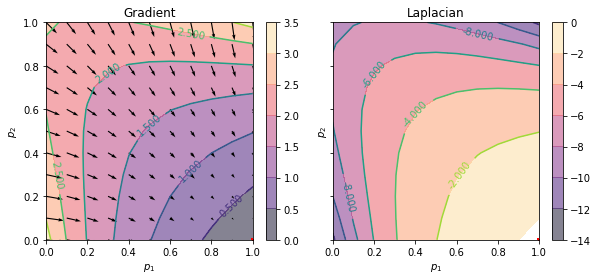

In [ ]:
fig = plot_dfn(focal_tversky, l=lb, r=rb, n=nb)

In [ ]:
works_for_regression(focal_tversky)

False

## Tversky with double focus (exploration)

Uses focus modulation at the example level and at the class level.

In [ ]:
def tversky_double_focus(p1, p2, l1, l2, alpha=0.4, beta=None, lmbda=0.9, gamma_class=1.8, gamma_example=2.0, eps=tf.keras.backend.epsilon()):
  class_fti = focal_tversky(p1, p2, l1, l2, alpha=alpha, beta=beta, gamma=gamma_class, eps=eps)
  example_ti = tversky_tilde(p1, p2, l1, l2, alpha=alpha, beta=beta, gamma=gamma_example, eps=eps)
  return lmbda * class_fti + (1.0 - lmbda) * example_ti

In [ ]:
composed_unit_test_binary(tversky_double_focus)

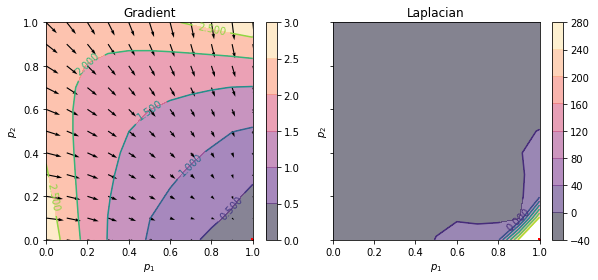

In [ ]:
fig = plot_dfn(tversky_double_focus, l=lb, r=rb, n=nb)

## $D_2$

$$ \frac{2.0 * \sum_i p_i l_i}{\sum_i (p_i^2 + l_i^2) } $$

Source: [1]

In [ ]:
@tf.function
def d2(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  num = 2.0 * (p1 * l1 + p2 * l2) + eps
  den = (p1 ** 2 + l1 ** 2) + (p2 ** 2 + l2 ** 2) + eps
  return num / den

In [ ]:
unit_test_binary(d2)

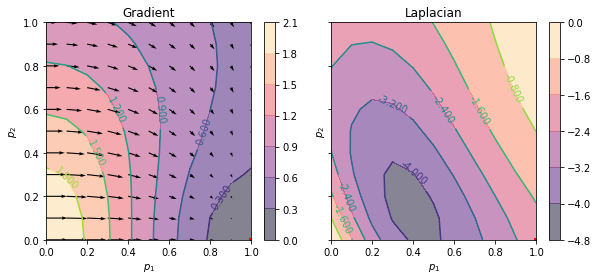

In [ ]:
fig = plot_dfn(d2, l=lb, r=rb, n=nb)

We see that this variant works for regression:

In [ ]:
works_for_regression(d2)

True

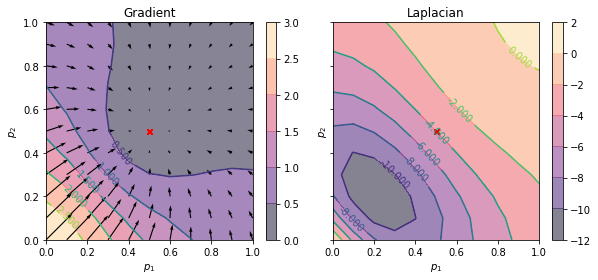

In [ ]:
fig = plot_dfn(d2, l=lc, r=rc, n=nc)

## $D_2$ complement

$$ \tilde{D}_2(p, l) = D_2(\vec{1} - p, \vec{1} - l)$$

Source: [1]

In [ ]:
@tf.function
def d2c(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  return d2(1.0 - p1, 1.0 - p2, 1.0 - l1, 1.0 - l2, eps=eps)

In [ ]:
# Sanity check (binary target)
d2c(1.0, 0.0, 1.0, 0.0).numpy()

1.0

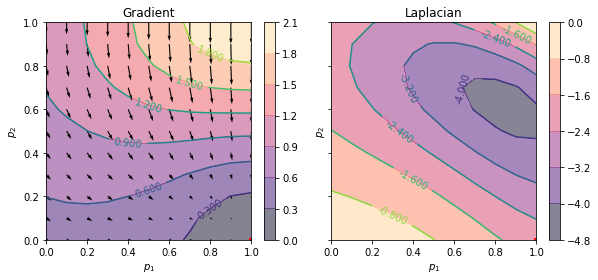

In [ ]:
fig = plot_dfn(d2c, l=lb, r=rb, n=nb)

In [ ]:
# Sanity check (continuous target)
d2c(0.3, 0.0, 0.3, 0.0).numpy()

1.0

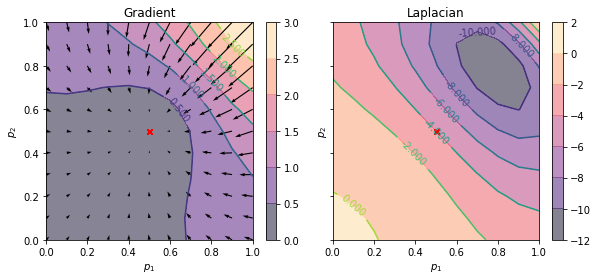

In [ ]:
fig = plot_dfn(d2c, l=lc, r=rc, n=nc)

## $D_2$ + $D_2$ complement (exploration)

In [ ]:
@tf.function
def d2m(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  return 0.5 * (d2(p1, p2, l1, l2, eps=eps) + d2c(p1, p2,l1,l2, eps=eps))

In [ ]:
# Sanity check (binary target)
d2m(1.0, 0.0, 1.0, 0.0).numpy()

1.0

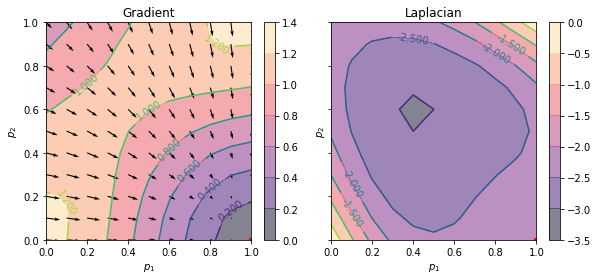

In [ ]:
fig = plot_dfn(d2m, l=lb, r=rb, n=nb)

In [ ]:
# Sanity check (continuous target)
d2m(0.3, 0.0, 0.3, 0.0).numpy()

1.0

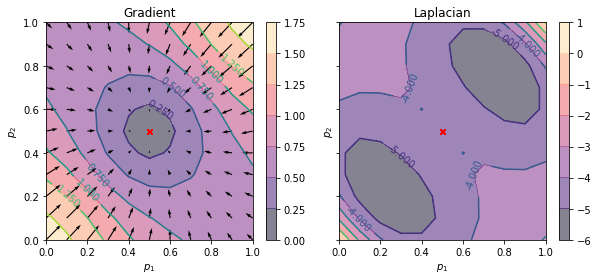

In [ ]:
fig = plot_dfn(d2m, l=lc, r=rc, n=nc)

## D3 (Tanimoto or $T$)

$$\frac{\sum_i p_i l_i}{\sum_i (p_i^2 + l_i^2) - \sum_i (p_i l_i)}$$

Source: [1]

In [ ]:
@tf.function
def d3(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  num = p1 * l1 + p2 * l2
  den = (p1 ** 2 + l1 ** 2) + (p2 ** 2 + l2 ** 2) - num
  return (num + eps) / (den + eps)

In [ ]:
unit_test_binary(d3)

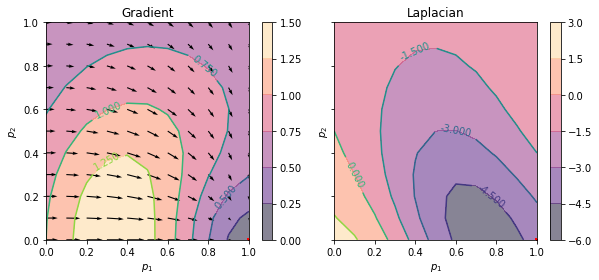

In [ ]:
fig = plot_dfn(d3, l=lb, r=rb, n=nb)

We see that it works for regression:

In [ ]:
works_for_regression(d3)

True

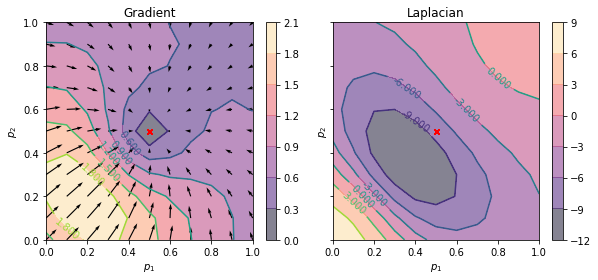

In [ ]:
fig = plot_dfn(d3, l=lc, r=rc, n=nc)

## $D_3$ complement

$$ \tilde{D}_3(p, l) = D_3(\vec{1} - p, \vec{1} - l)$$

Source: [1]

In [ ]:
@tf.function
def d3c(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  return d3(1.0 - p1, 1.0 - p2, 1.0 - l1, 1.0 - l2, eps=eps)

In [ ]:
complement_unit_test_binary(d3c)

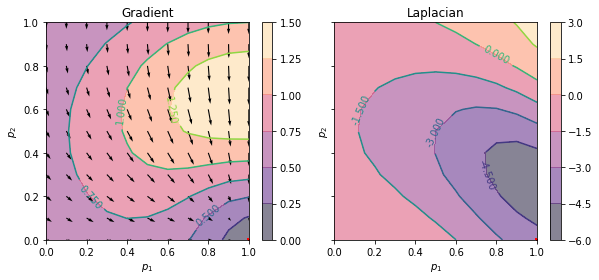

In [ ]:
fig = plot_dfn(d3c, l=lb, r=rb, n=nb)

In [ ]:
works_for_regression(d3c)

True

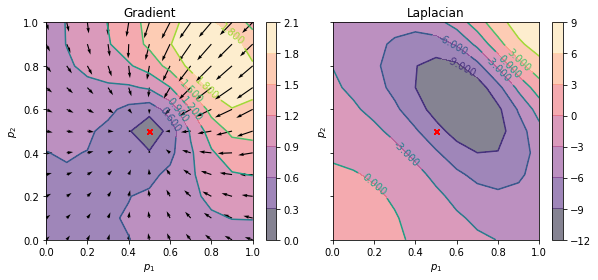

In [ ]:
fig = plot_dfn(d3c, l=lc, r=rc, n=nc)

## $\tilde{T}$ ($D_3$ + $D_3$ complement)

Recall $D_3 \equiv T$

$$ \tilde{T}(p_i, l_i) = \frac{T(p_i, l_i) + T(1 - p_i, 1 - l_i)}{2} $$

Source: [1]

In [ ]:
@tf.function
def d3m(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  return 0.5 * (d3(p1, p2, l1, l2, eps=eps) + d3c(p1, p2,l1,l2, eps=eps))

In [ ]:
composed_unit_test_binary(d3m)

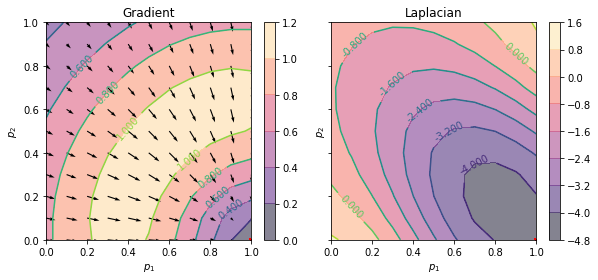

In [ ]:
fig = plot_dfn(d3m, l=lb, r=rb, n=nb)

In [ ]:
works_for_regression(d3m)

True

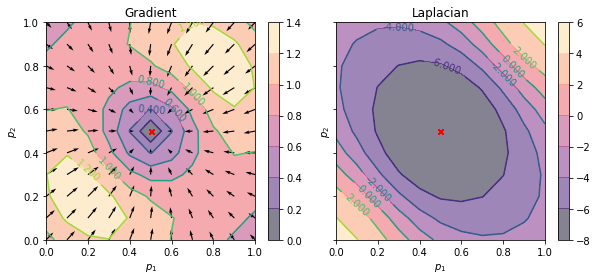

In [ ]:
fig = plot_dfn(d3m, l=lc, r=rc, n=nc)

## Focal $\tilde{T}$ (exploration)

We attempt to merge the approach in [3] with the approach in [4].

In [ ]:
@tf.function
def focal_d3m(p1, p2, l1, l2, gamma=1.8, eps=tf.keras.backend.epsilon()):
  ft = tf.math.pow(1.0 - d3(p1, p2, l1, l2, eps=eps), gamma)
  fnt = tf.math.pow(1.0 - d3c(p1, p2,l1,l2, eps=eps), gamma)
  # By definition it is a loss, so we add 1.0 for the plots.
  return 1.0 - (ft + fnt)

In [ ]:
composed_unit_test_binary(focal_d3m)

We see some undefined values on the second plot.

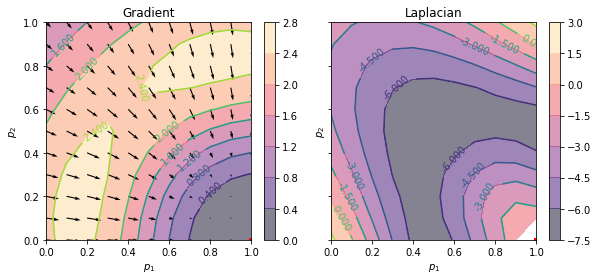

In [ ]:
fig = plot_dfn(focal_d3m, l=lb, r=rb, n=nb)

In [ ]:
works_for_regression(focal_d3m)

True

We see some undefined values in the second plot.

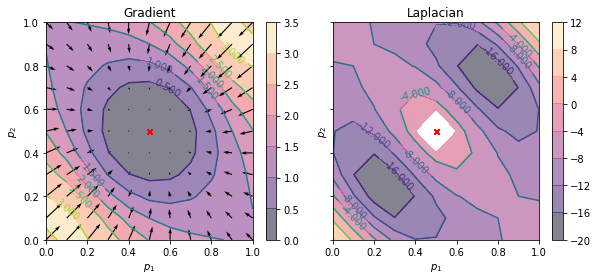

In [ ]:
fig = plot_dfn(focal_d3m, l=lc, r=rc, n=nc)

## Log Cosh $D_1$

$$ \log \cosh (D_1(p, l)) $$ Source: [3]

In [ ]:
@tf.function
def log_cosh_d1(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  num = 2.0 * (p1 * l1 + p2 * l2) + eps
  den = p1 + p2 + l1 + l2 + eps
  d1 = num / den
  # By definition it is a loss, so we add 1.0 for the plots.
  return 1.0 - tf.math.log(tf.math.cosh(1.0 - d1))

In [ ]:
composed_unit_test_binary(log_cosh_d1)

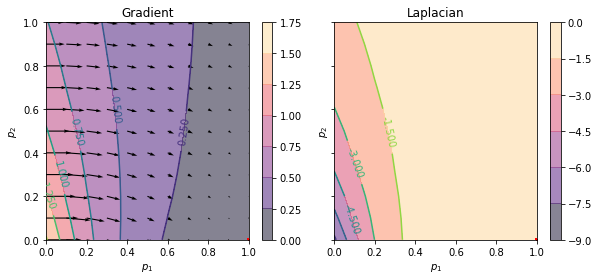

In [ ]:
fig = plot_dfn(log_cosh_d1, l=lb, r=rb, n=nb)

In [ ]:
works_for_regression(log_cosh_d1)

False

## Log $D_1$

$$\log (D_1(p, l)) $$

Source: [3]

In [ ]:
@tf.function
def log_d1(p1, p2, l1, l2, eps=tf.keras.backend.epsilon()):
  # By definition it is a loss, so we add 1.0 for the plots.
  return 1.0 - tf.math.log(d1(p1, p2, l1, l2, eps=eps))

In [ ]:
composed_unit_test_binary(log_d1)

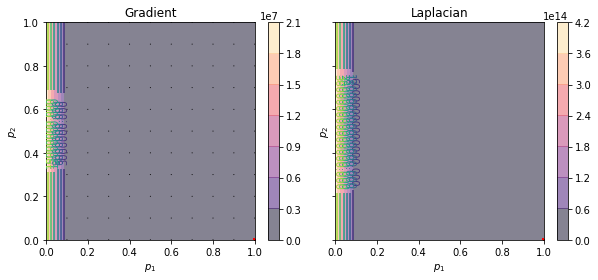

In [ ]:
fig = plot_dfn(log_d1, l=lb, r=rb, n=nb)

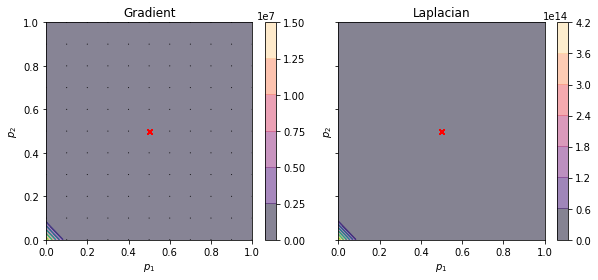

In [ ]:
fig = plot_dfn(log_d1, l=lc, r=rc, n=nc)

## Binary cross-entropy loss

$$ -\frac{1}{n} \sum_i^n \left[ l_i \log (p_i) + (1.0 - l_i) \log (1.0 - p_i) \right] $$

In [ ]:
@tf.function
def binary_crossentropy(p1, p2, l1, l2):
  bce = tf.keras.losses.BinaryCrossentropy(from_logits=False,
                                           reduction=tf.keras.losses.Reduction.NONE,
                                           )
  loss = 0.5 * (bce(l1, p1) + bce(l2, p2))
  # By definition it is a loss, so we add 1.0 for the plots.
  return 1.0 - loss  # multiply by -1 to reflect opt direction

In [ ]:
composed_unit_test_binary(binary_crossentropy)

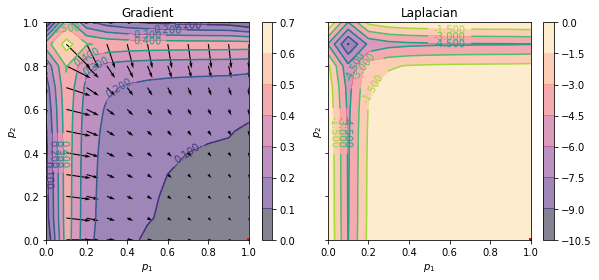

In [ ]:
fig = plot_dfn(binary_crossentropy, l=lb, r=rb, n=nb)

It won't work correctly for regression of a continuous target:

In [ ]:
works_for_regression(binary_crossentropy)

False

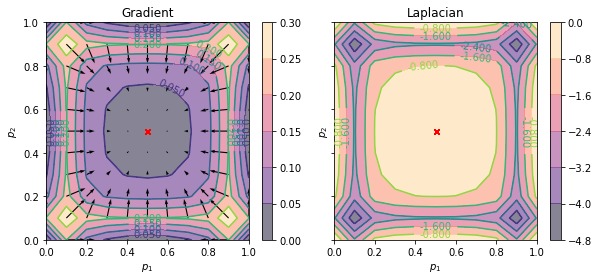

In [ ]:
fig = plot_dfn(binary_crossentropy, l=lc, r=rc, n=nc)

## Focal loss

Source: [2]

In [ ]:
@tf.function
def focal_loss(p1, p2, l1, l2, gamma=2.0):
  bce = tf.keras.losses.BinaryCrossentropy(from_logits=False,
                                           reduction=tf.keras.losses.Reduction.NONE,
                                           )

  prob1 = (l1 * p1) + (1 - l1) * (1 - p1)
  prob2 = (l1 * p1) + (1 - l1) * (1 - p1)
  modulating_factor1 = tf.pow(1.0 - prob1, gamma)
  modulating_factor2 = tf.pow(1.0 - prob2, gamma)

  l1 = modulating_factor1 * bce(l1, p1)
  l2 = modulating_factor2 * bce(l2, p2)
  loss = 0.5 * (l1 + l2)

  return 1.0 - loss

In [ ]:
composed_unit_test_binary(focal_loss)

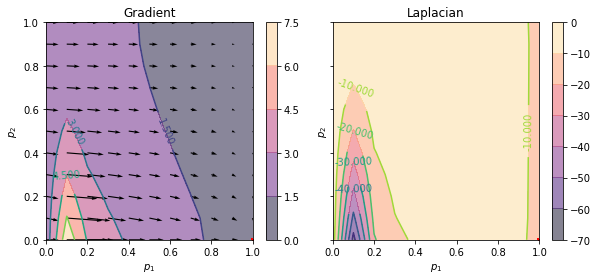

In [ ]:
fig = plot_dfn(focal_loss, l=lb, r=rb, n=nb)

It doesn't work well for regression of a continuous variable:

In [ ]:
works_for_regression(focal_loss)

False

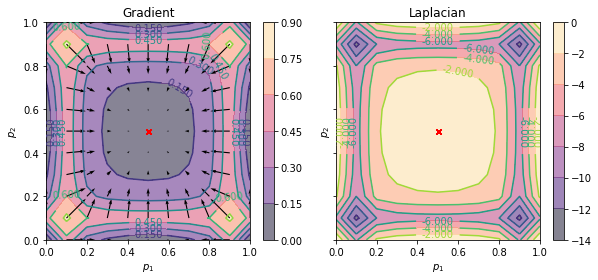

In [ ]:
fig = plot_dfn(focal_loss, l=lc, r=rc, n=nc)

## MSE

$$ \frac{1}{n} \sum_i^n (p_i - l_i)^2  $$

In [ ]:
@tf.function
def mse(p1, p2, l1, l2):
  d1 = tf.keras.losses.mean_squared_error(l1, p1)
  d2 = tf.keras.losses.mean_squared_error(l2, p2)
  loss = (0.5 * (d1 + d2))
  return 1.0 - loss

In [ ]:
composed_unit_test_binary(mse)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: No contour levels were found within the data range.


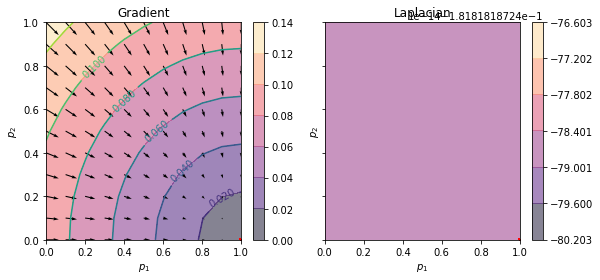

In [ ]:
fig = plot_dfn(mse, l=lb, r=rb, n=nb)

In [ ]:
works_for_regression(mse)

True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: No contour levels were found within the data range.


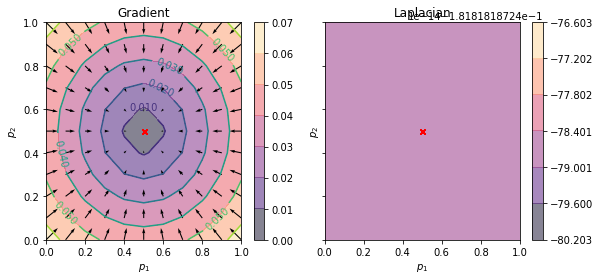

In [ ]:
fig = plot_dfn(mse, l=lc, r=rc, n=nc)

## MAE

$$ -\frac{1}{n} \sum_i^n |p_i - l_i|  $$

In [ ]:
@tf.function
def mae(p1, p2, l1, l2):
  xd = tf.abs(p1 - l1)
  yd = tf.abs(p2 - l2)
  loss = 0.5 * (xd + yd)
  return 1.0 - loss

In [ ]:
composed_unit_test_binary(mae)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: No contour levels were found within the data range.


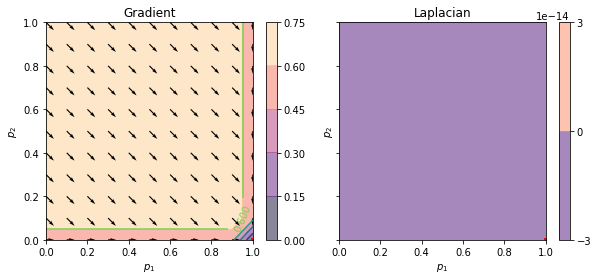

In [ ]:
fig = plot_dfn(mae, l=lb, r=rb, n=nb)

In [ ]:
works_for_regression(mae)

True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: No contour levels were found within the data range.


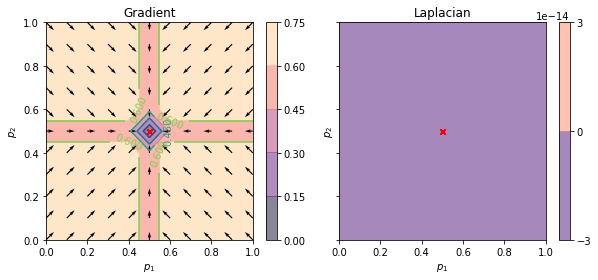

In [ ]:
fig = plot_dfn(mae, l=lc, r=rc, n=nc)